In [1]:
# 第一步：导入必要的库
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
import re
from collections import Counter
import random
import matplotlib.pyplot as plt

# 设置随机种子以确保可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

print("所有必要的库已导入")

所有必要的库已导入


In [2]:
# 第二步：加载和查看数据（修改版）
print("正在加载数据...")

# 指定列名（根据描述，CSV有三列：polarity, title, text）
column_names = ['polarity', 'title', 'text']

# 加载训练集（只取前10000行）
train_df = pd.read_csv('train.csv', names=column_names, nrows=10000)
test_df = pd.read_csv('test.csv', names=column_names)
dev_df = pd.read_csv('dev.csv', names=column_names)

print(f"训练集大小: {len(train_df)}")
print(f"测试集大小: {len(test_df)}")
print(f"验证集大小: {len(dev_df)}")

# 查看数据的前几行
print("\n训练集前5行:")
print(train_df.head())

# 检查标签分布
print("\n训练集标签分布:")
print(train_df['polarity'].value_counts())
print("\n测试集标签分布:")
print(test_df['polarity'].value_counts())
print("\n验证集标签分布:")
print(dev_df['polarity'].value_counts())

# 注意：polarity列中1表示负面，2表示正面
# 我们需要将其转换为0和1（负面为0，正面为1）
train_df['label'] = train_df['polarity'] - 1
test_df['label'] = test_df['polarity'] - 1
dev_df['label'] = dev_df['polarity'] - 1

print(f"\n标签转换完成: 负面(1)→{train_df.loc[0, 'label']}, 正面(2)→{train_df.loc[train_df['polarity']==2, 'label'].iloc[0]}")

正在加载数据...
训练集大小: 10000
测试集大小: 1001
验证集大小: 1001

训练集前5行:
   polarity                                              title  \
0         2                     Stuning even for the non-gamer   
1         2              The best soundtrack ever to anything.   
2         2                                           Amazing!   
3         2                               Excellent Soundtrack   
4         2  Remember, Pull Your Jaw Off The Floor After He...   

                                                text  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...  

训练集标签分布:
polarity
1    5097
2    4903
Name: count, dtype: int64

测试集标签分布:
polarity
2    507
1    494
Name: count, dtype: int64

验证集标签分布:
polarity
1    511
2    490
Name: count, dtype: int64

标签转换完成: 负面(1)→1, 正面(2)→1


In [3]:
# 第三步：数据预处理（简化版）
print("\n正在预处理数据...")

def preprocess_text(text):
    """
    文本预处理函数
    """
    if pd.isna(text):
        return ""
    
    # 转换为小写
    text = text.lower()
    
    # 移除HTML标签（如果有）
    text = re.sub(r'<.*?>', '', text)
    
    # 移除URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 移除特殊字符和数字，但保留基本的标点用于情感分析
    # 我们可以保留一些标点，如!和?，因为它们可能对情感分析有用
    text = re.sub(r'[^a-zA-Z\s!?]', ' ', text)
    
    # 移除多余的空格
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def simple_tokenize(text):
    """
    简单分词方法：按空格分词，并处理标点符号
    """
    # 将标点符号与单词分开
    text = re.sub(r'([!?])', r' \1 ', text)
    # 按空格分词
    tokens = text.split()
    return tokens

# 对三个数据集的文本列进行预处理
print("正在清洗训练集文本...")
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
print("正在清洗测试集文本...")
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)
print("正在清洗验证集文本...")
dev_df['cleaned_text'] = dev_df['text'].apply(preprocess_text)

# 使用简单分词
print("正在对训练集文本进行分词...")
train_df['tokens'] = train_df['cleaned_text'].apply(simple_tokenize)
print("正在对测试集文本进行分词...")
test_df['tokens'] = test_df['cleaned_text'].apply(simple_tokenize)
print("正在对验证集文本进行分词...")
dev_df['tokens'] = dev_df['cleaned_text'].apply(simple_tokenize)

# 查看预处理后的样例
print("\n预处理前后的文本对比:")
print("原始文本:", train_df.loc[0, 'text'][:100] + "...")
print("清洗后文本:", train_df.loc[0, 'cleaned_text'][:100] + "...")
print("分词结果:", train_df.loc[0, 'tokens'][:10], "...")

# 计算一些统计信息
all_tokens = [token for tokens in train_df['tokens'] for token in tokens]
vocab_size = len(set(all_tokens))
avg_length = np.mean([len(tokens) for tokens in train_df['tokens']])

print(f"\n词汇表大小: {vocab_size}")
print(f"平均文本长度: {avg_length:.2f} 个词")
print("使用简单分词方法（空格分词）")


正在预处理数据...
正在清洗训练集文本...
正在清洗测试集文本...
正在清洗验证集文本...
正在对训练集文本进行分词...
正在对测试集文本进行分词...
正在对验证集文本进行分词...

预处理前后的文本对比:
原始文本: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even t...
清洗后文本: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even t...
分词结果: ['this', 'sound', 'track', 'was', 'beautiful', '!', 'it', 'paints', 'the', 'senery'] ...

词汇表大小: 29835
平均文本长度: 77.67 个词
使用简单分词方法（空格分词）


In [4]:
# 第四步：创建词汇表和构建数据集
print("\n正在创建词汇表...")

class Vocabulary:
    def __init__(self, min_freq=2):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.min_freq = min_freq
        
    def build_vocab(self, token_lists):
        """根据token列表构建词汇表"""
        # 统计词频
        word_freq = Counter()
        for tokens in token_lists:
            word_freq.update(tokens)
        
        print(f"原始词汇表大小（所有出现的token）: {len(word_freq)}")
        
        # 过滤低频词
        words = [word for word, count in word_freq.items() if count >= self.min_freq]
        
        # 构建映射
        for idx, word in enumerate(words, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word
            
        print(f"过滤后词汇表大小（频率≥{self.min_freq}）: {len(self)}")
        
    def numericalize(self, tokens):
        """将token列表转换为索引列表"""
        return [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokens]
    
    def __len__(self):
        return len(self.word2idx)

# 创建词汇表
vocab = Vocabulary(min_freq=2)
vocab.build_vocab(train_df['tokens'])

print(f"\n词汇表大小（包括<PAD>和<UNK>）: {len(vocab)}")
print(f"前10个词汇:")
for i in range(10):
    if i in vocab.idx2word:
        print(f"  {i}: {vocab.idx2word[i]}")

# 定义数据集类
class AmazonReviewDataset(Dataset):
    def __init__(self, df, vocab, max_len=100):
        self.df = df
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        tokens = self.df.iloc[idx]['tokens']
        label = self.df.iloc[idx]['label']
        
        # 将tokens转换为索引
        indices = self.vocab.numericalize(tokens)
        
        # 截断或填充到固定长度
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            indices = indices + [0] * (self.max_len - len(indices))
        
        return {
            'text': torch.tensor(indices, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 创建数据集实例
max_len = 100  # 固定文本长度
train_dataset = AmazonReviewDataset(train_df, vocab, max_len=max_len)
test_dataset = AmazonReviewDataset(test_df, vocab, max_len=max_len)
dev_dataset = AmazonReviewDataset(dev_df, vocab, max_len=max_len)

print(f"\n数据集创建完成，最大序列长度: {max_len}")
print(f"训练集样本数: {len(train_dataset)}")
print(f"测试集样本数: {len(test_dataset)}")
print(f"验证集样本数: {len(dev_dataset)}")

# 测试一个样本
sample = train_dataset[0]
print(f"\n一个样本的结构:")
print(f"文本索引形状: {sample['text'].shape}")
print(f"标签: {sample['label'].item()}")
print(f"文本前10个索引: {sample['text'][:10]}")
print(f"文本前10个字符: {[vocab.idx2word.get(idx.item(), '?') for idx in sample['text'][:10]]}")


正在创建词汇表...
原始词汇表大小（所有出现的token）: 29835
过滤后词汇表大小（频率≥2）: 15752

词汇表大小（包括<PAD>和<UNK>）: 15752
前10个词汇:
  0: <PAD>
  1: <UNK>
  2: this
  3: sound
  4: track
  5: was
  6: beautiful
  7: !
  8: it
  9: paints

数据集创建完成，最大序列长度: 100
训练集样本数: 10000
测试集样本数: 1001
验证集样本数: 1001

一个样本的结构:
文本索引形状: torch.Size([100])
标签: 1
文本前10个索引: tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10,  1])
文本前10个字符: ['this', 'sound', 'track', 'was', 'beautiful', '!', 'it', 'paints', 'the', '<UNK>']


In [5]:
# 第五步：创建数据加载器
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

print(f"\n数据加载器创建完成")
print(f"批量大小: {batch_size}")
print(f"训练集批次数量: {len(train_loader)}")
print(f"测试集批次数量: {len(test_loader)}")
print(f"验证集批次数量: {len(dev_loader)}")

# 测试一个批次
for batch in train_loader:
    print(f"\n一个批次的结构:")
    print(f"文本批次形状: {batch['text'].shape}")  # [batch_size, max_len]
    print(f"标签批次形状: {batch['label'].shape}")  # [batch_size]
    print(f"标签示例: {batch['label'][:10].numpy()}")
    break


数据加载器创建完成
批量大小: 64
训练集批次数量: 157
测试集批次数量: 16
验证集批次数量: 16

一个批次的结构:
文本批次形状: torch.Size([64, 100])
标签批次形状: torch.Size([64])
标签示例: [1 0 0 1 0 0 0 1 0 1]


In [6]:
# 第六步：定义TextCNN模型
print("\n正在定义TextCNN模型...")

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, 
                 kernel_sizes=[3, 4, 5], num_filters=100, dropout=0.5):
        super(TextCNN, self).__init__()
        
        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # 多个并行的卷积层，每个对应不同的kernel size
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, 
                     out_channels=num_filters, 
                     kernel_size=k)
            for k in kernel_sizes
        ])
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
        # 全连接层
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)
        
    def forward(self, x):
        """
        前向传播
        x: [batch_size, seq_len]
        """
        # 词嵌入: [batch_size, seq_len] -> [batch_size, seq_len, embed_dim]
        x_embed = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        
        # 调整维度以适应Conv1d: [batch_size, embed_dim, seq_len]
        x_embed = x_embed.permute(0, 2, 1)  # [batch_size, embed_dim, seq_len]
        
        # 对每个卷积层应用卷积和ReLU激活，然后进行最大池化
        conv_outputs = []
        for conv in self.convs:
            # 卷积: [batch_size, num_filters, seq_len - kernel_size + 1]
            conv_out = torch.relu(conv(x_embed))
            
            # 最大池化: [batch_size, num_filters]
            pool_out = torch.max(conv_out, dim=2)[0]
            conv_outputs.append(pool_out)
        
        # 拼接所有卷积层的输出
        concat = torch.cat(conv_outputs, dim=1)  # [batch_size, len(kernel_sizes)*num_filters]
        
        # Dropout
        concat = self.dropout(concat)
        
        # 全连接层
        output = self.fc(concat)  # [batch_size, num_classes]
        
        return output

# 模型参数设置
vocab_size = len(vocab)
embed_dim = 100  # 词向量维度
num_classes = 2  # 正面和负面
kernel_sizes = [3, 5]  # 按照实验要求，选择3和5的卷积核

# 创建模型实例
model = TextCNN(vocab_size, embed_dim, num_classes, kernel_sizes=kernel_sizes)

print(f"模型参数:")
print(f"- 词汇表大小: {vocab_size}")
print(f"- 词向量维度: {embed_dim}")
print(f"- 类别数: {num_classes}")
print(f"- 卷积核大小: {kernel_sizes}")
print(f"- 卷积核数量: {100}")  # num_filters默认值

# 测试模型
test_input = torch.randint(0, vocab_size, (2, max_len))  # 创建2个样本
output = model(test_input)
print(f"\n模型测试:")
print(f"输入形状: {test_input.shape}")
print(f"输出形状: {output.shape}")
print(f"输出示例:\n{output}")


正在定义TextCNN模型...
模型参数:
- 词汇表大小: 15752
- 词向量维度: 100
- 类别数: 2
- 卷积核大小: [3, 5]
- 卷积核数量: 100

模型测试:
输入形状: torch.Size([2, 100])
输出形状: torch.Size([2, 2])
输出示例:
tensor([[ 2.0014,  0.2640],
        [-0.5445,  1.8678]], grad_fn=<AddmmBackward0>)


In [7]:
# 第七步（改进版）：定义训练和评估函数
print("\n正在定义改进的训练和评估函数...")

def train_epoch_improved(model, data_loader, optimizer, criterion, device, grad_clip=1.0):
    """
    训练一个epoch，添加梯度裁剪
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, batch in enumerate(data_loader):
        texts = batch['text'].to(device)
        labels = batch['label'].to(device)
        
        # 前向传播
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪
        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        
        # 统计
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 每50个batch打印一次进度
        if batch_idx % 50 == 0:
            batch_acc = (predicted == labels).sum().item() / labels.size(0)
            print(f"  Batch {batch_idx:3d}/{len(data_loader)} - Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}")
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

def evaluate_improved(model, data_loader, criterion, device):
    """
    评估模型
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            # 前向传播
            outputs = model(texts)
            loss = criterion(outputs, labels)
            
            # 统计
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 将模型移到设备上（需要重新创建模型，因为之前的模型可能有问题）
print("\n重新创建TextCNN模型...")

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, 
                 kernel_sizes=[3, 4, 5], num_filters=100, dropout=0.5):
        super(TextCNN, self).__init__()
        
        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # 多个并行的卷积层，每个对应不同的kernel size
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, 
                     out_channels=num_filters, 
                     kernel_size=k)
            for k in kernel_sizes
        ])
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
        # 全连接层
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)
        
        # 初始化权重
        self._init_weights()
        
    def _init_weights(self):
        """权重初始化"""
        for conv in self.convs:
            nn.init.kaiming_normal_(conv.weight, mode='fan_out', nonlinearity='relu')
            nn.init.constant_(conv.bias, 0)
        
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        
    def forward(self, x):
        """
        前向传播
        x: [batch_size, seq_len]
        """
        # 词嵌入: [batch_size, seq_len] -> [batch_size, seq_len, embed_dim]
        x_embed = self.embedding(x)
        
        # 调整维度以适应Conv1d: [batch_size, embed_dim, seq_len]
        x_embed = x_embed.permute(0, 2, 1)
        
        # 对每个卷积层应用卷积和ReLU激活，然后进行最大池化
        conv_outputs = []
        for conv in self.convs:
            # 卷积
            conv_out = torch.relu(conv(x_embed))
            # 最大池化
            pool_out = torch.max(conv_out, dim=2)[0]
            conv_outputs.append(pool_out)
        
        # 拼接所有卷积层的输出
        concat = torch.cat(conv_outputs, dim=1)
        
        # Dropout
        concat = self.dropout(concat)
        
        # 全连接层
        output = self.fc(concat)
        
        return output

# 模型参数设置
vocab_size = len(vocab)
embed_dim = 128  # 增加词向量维度
num_classes = 2  # 正面和负面
kernel_sizes = [3, 5]  # 按照实验要求，选择3和5的卷积核

# 创建模型实例
model = TextCNN(vocab_size, embed_dim, num_classes, kernel_sizes=kernel_sizes)
model = model.to(device)

print(f"模型参数:")
print(f"- 词汇表大小: {vocab_size}")
print(f"- 词向量维度: {embed_dim}")
print(f"- 类别数: {num_classes}")
print(f"- 卷积核大小: {kernel_sizes}")
print(f"- 卷积核数量: {100}")
print(f"- Dropout率: {0.5}")

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # 添加权重衰减

# 添加学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("\n训练配置:")
print(f"- 损失函数: {criterion.__class__.__name__}")
print(f"- 优化器: {optimizer.__class__.__name__}")
print(f"- 初始学习率: {optimizer.param_groups[0]['lr']}")
print(f"- 权重衰减: {optimizer.param_groups[0]['weight_decay']}")
print(f"- 学习率调度器: ReduceLROnPlateau")


正在定义改进的训练和评估函数...
使用设备: cpu

重新创建TextCNN模型...
模型参数:
- 词汇表大小: 15752
- 词向量维度: 128
- 类别数: 2
- 卷积核大小: [3, 5]
- 卷积核数量: 100
- Dropout率: 0.5

训练配置:
- 损失函数: CrossEntropyLoss
- 优化器: Adam
- 初始学习率: 0.001
- 权重衰减: 0.0001
- 学习率调度器: ReduceLROnPlateau


In [8]:
# 创建保存模型的目录
import os
if not os.path.exists('saved_model'):
    os.makedirs('saved_model')
    print("创建目录: saved_model")

# 现在继续第八步的代码（改进版）：训练模型
print("\n开始训练模型...")

num_epochs = 10  # 训练轮数
train_losses = []
train_accuracies = []
dev_losses = []
dev_accuracies = []

# 早停参数
patience = 3
best_dev_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"{'='*50}")
    
    # 训练
    train_loss, train_acc = train_epoch_improved(
        model, train_loader, optimizer, criterion, device, grad_clip=1.0
    )
    
    # 验证
    dev_loss, dev_acc = evaluate_improved(model, dev_loader, criterion, device)
    
    # 更新学习率
    scheduler.step(dev_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # 保存指标
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}] 结果:")
    print(f"  训练 - 损失: {train_loss:.4f}, 准确率: {train_acc:.4f}")
    print(f"  验证 - 损失: {dev_loss:.4f}, 准确率: {dev_acc:.4f}")
    print(f"  当前学习率: {current_lr:.6f}")
    
    # 早停检查
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'dev_loss': dev_loss,
            'train_acc': train_acc,
            'dev_acc': dev_acc,
        }, 'saved_model/best_model_checkpoint.pth')
        print(f"  保存最佳模型 (验证损失: {dev_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  早停计数器: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"\n早停触发! 在 epoch {epoch+1} 停止训练")
            break

print("\n训练完成!")


开始训练模型...

Epoch [1/10]
  Batch   0/157 - Loss: 3.1025, Acc: 0.4531
  Batch  50/157 - Loss: 2.9471, Acc: 0.4375
  Batch 100/157 - Loss: 1.5058, Acc: 0.5312
  Batch 150/157 - Loss: 1.4527, Acc: 0.4844

Epoch [1/10] 结果:
  训练 - 损失: 1.8385, 准确率: 0.5381
  验证 - 损失: 0.6333, 准确率: 0.6424
  当前学习率: 0.001000
  保存最佳模型 (验证损失: 0.6333)

Epoch [2/10]
  Batch   0/157 - Loss: 1.0172, Acc: 0.5938
  Batch  50/157 - Loss: 1.1853, Acc: 0.5000
  Batch 100/157 - Loss: 0.8022, Acc: 0.5156
  Batch 150/157 - Loss: 0.5965, Acc: 0.6250

Epoch [2/10] 结果:
  训练 - 损失: 0.7975, 准确率: 0.6156
  验证 - 损失: 0.5656, 准确率: 0.7303
  当前学习率: 0.001000
  保存最佳模型 (验证损失: 0.5656)

Epoch [3/10]
  Batch   0/157 - Loss: 0.6350, Acc: 0.7031
  Batch  50/157 - Loss: 0.5610, Acc: 0.7656
  Batch 100/157 - Loss: 0.4971, Acc: 0.7344
  Batch 150/157 - Loss: 0.6170, Acc: 0.6250

Epoch [3/10] 结果:
  训练 - 损失: 0.6150, 准确率: 0.6664
  验证 - 损失: 0.5857, 准确率: 0.6843
  当前学习率: 0.001000
  早停计数器: 1/3

Epoch [4/10]
  Batch   0/157 - Loss: 0.5912, Acc: 0.7344
  Batc

In [9]:
# 第九步：测试模型
print("\n正在测试模型...")

# 加载最佳模型
checkpoint = torch.load('saved_model/best_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"加载最佳模型 (来自 epoch {checkpoint['epoch']+1})")

# 在测试集上评估模型
test_loss, test_accuracy = evaluate_improved(model, test_loader, criterion, device)
print(f"\n测试集结果:")
print(f"  损失: {test_loss:.4f}")
print(f"  准确率: {test_accuracy:.4f}")

# 计算详细指标
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_detailed_metrics(model, data_loader, device):
    """
    计算精确率、召回率和F1分数等详细指标
    """
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(all_predictions)
    labels = np.array(all_labels)
    
    # 计算指标
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')
    cm = confusion_matrix(labels, predictions)
    
    # 分类报告
    report = classification_report(labels, predictions, target_names=['负面', '正面'], digits=4)
    
    return precision, recall, f1, cm, report

# 在测试集上计算详细指标
test_precision, test_recall, test_f1, test_cm, test_report = calculate_detailed_metrics(model, test_loader, device)

print(f"\n测试集详细指标:")
print(f"  精确率: {test_precision:.4f}")
print(f"  召回率: {test_recall:.4f}")
print(f"  F1分数: {test_f1:.4f}")
print(f"\n混淆矩阵:")
print(f"  {test_cm}")
print(f"\n分类报告:")
print(test_report)


正在测试模型...
加载最佳模型 (来自 epoch 10)

测试集结果:
  损失: 0.3669
  准确率: 0.8272

测试集详细指标:
  精确率: 0.8599
  召回率: 0.7870
  F1分数: 0.8218

混淆矩阵:
  [[429  65]
 [108 399]]

分类报告:
              precision    recall  f1-score   support

          负面     0.7989    0.8684    0.8322       494
          正面     0.8599    0.7870    0.8218       507

    accuracy                         0.8272      1001
   macro avg     0.8294    0.8277    0.8270      1001
weighted avg     0.8298    0.8272    0.8270      1001




可视化训练过程...


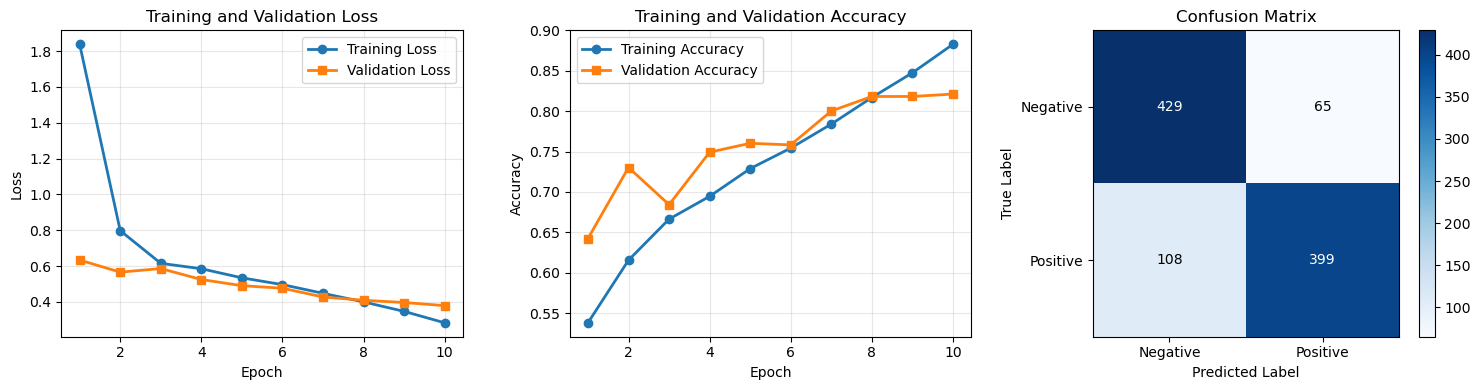


训练结果摘要:
训练轮数: 10
最终训练准确率: 0.8828
最终验证准确率: 0.8212
测试集准确率: 0.8272
测试集精确率: 0.8599
测试集召回率: 0.7870
测试集F1分数: 0.8218


In [10]:
# 第十步：可视化训练过程（英文图表）
print("\n可视化训练过程...")

# 创建图表
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 损失曲线
epochs_range = range(1, len(train_losses) + 1)
axes[0].plot(epochs_range, train_losses, label='Training Loss', marker='o', linewidth=2)
axes[0].plot(epochs_range, dev_losses, label='Validation Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 准确率曲线
axes[1].plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o', linewidth=2)
axes[1].plot(epochs_range, dev_accuracies, label='Validation Accuracy', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. 混淆矩阵热力图
im = axes[2].imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[2].figure.colorbar(im, ax=axes[2])
axes[2].set(xticks=[0, 1], yticks=[0, 1],
           xticklabels=['Negative', 'Positive'], 
           yticklabels=['Negative', 'Positive'],
           title='Confusion Matrix',
           ylabel='True Label',
           xlabel='Predicted Label')

# 在热力图中添加文本
thresh = test_cm.max() / 2.
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        axes[2].text(j, i, format(test_cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if test_cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# 打印最终训练结果摘要
print("\n" + "="*60)
print("训练结果摘要:")
print("="*60)
print(f"训练轮数: {len(train_losses)}")
print(f"最终训练准确率: {train_accuracies[-1]:.4f}")
print(f"最终验证准确率: {dev_accuracies[-1]:.4f}")
print(f"测试集准确率: {test_accuracy:.4f}")
print(f"测试集精确率: {test_precision:.4f}")
print(f"测试集召回率: {test_recall:.4f}")
print(f"测试集F1分数: {test_f1:.4f}")
print("="*60)

In [13]:
# 重新定义预处理函数
print("\n重新定义预处理函数...")

def preprocess_text_english(text):
    """
    英文文本预处理函数
    """
    if pd.isna(text):
        return ""
    
    # 转换为小写
    text = text.lower()
    
    # 移除HTML标签
    text = re.sub(r'<.*?>', '', text)
    
    # 移除URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 移除特殊字符，保留字母、数字和基本标点
    text = re.sub(r'[^a-zA-Z0-9\s!?.,]', ' ', text)
    
    # 移除多余的空格
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_english(text):
    """
    英文分词
    """
    return text.split()

# 第十一步：创建预测函数（修正版）
print("\n创建预测函数...")

def predict_single_review(review_text, model, vocab, max_len=100):
    """
    预测单个评论的情感（英文）
    """
    # 使用英文预处理函数
    cleaned_text = preprocess_text_english(review_text)
    tokens = tokenize_english(cleaned_text)
    
    # 转换为索引
    indices = []
    for token in tokens:
        idx = vocab.word2idx.get(token, vocab.word2idx["<UNK>"])
        indices.append(idx)
    
    # 填充或截断
    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        indices = indices + [0] * (max_len - len(indices))
    
    # 创建tensor
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    
    # 预测
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)
    
    sentiment = "正面" if predicted.item() == 1 else "负面"
    confidence = probs[0][predicted.item()].item()
    
    return sentiment, confidence, {
        'negative_prob': probs[0][0].item(),
        'positive_prob': probs[0][1].item(),
        'raw_output': output[0].cpu().numpy()
    }

# 测试一些例子
print("\n测试预测函数:")
print("-" * 60)

# 使用英文测试示例
test_examples = [
    "This product is amazing, I love it!",
    "Very poor quality, do not recommend.",
    "It's okay, nothing special.",
    "Great value for the price.",
    "Terrible experience, completely disappointed."
]

for i, example in enumerate(test_examples, 1):
    print(f"示例 {i}:")
    print(f"  文本: {example}")
    
    # 使用预处理函数进行清洗
    cleaned = preprocess_text_english(example)
    tokens = tokenize_english(cleaned)
    
    # 转换为索引
    indices = []
    for token in tokens:
        idx = vocab.word2idx.get(token, vocab.word2idx["<UNK>"])
        indices.append(idx)
    
    print(f"  清洗后: {cleaned}")
    print(f"  分词: {tokens}")
    print(f"  有效词汇: {len([i for i in indices if i > 1])}/{len(indices)} (非UNK)")
    
    # 进行预测
    sentiment, confidence, details = predict_single_review(example, model, vocab)
    
    print(f"  预测结果: {sentiment}")
    print(f"  置信度: {confidence:.4f}")
    print(f"  负面概率: {details['negative_prob']:.4f}, 正面概率: {details['positive_prob']:.4f}")
    print("-" * 60)


重新定义预处理函数...

创建预测函数...

测试预测函数:
------------------------------------------------------------
示例 1:
  文本: This product is amazing, I love it!
  清洗后: this product is amazing, i love it!
  分词: ['this', 'product', 'is', 'amazing,', 'i', 'love', 'it!']
  有效词汇: 5/7 (非UNK)
  预测结果: 正面
  置信度: 0.8958
  负面概率: 0.1042, 正面概率: 0.8958
------------------------------------------------------------
示例 2:
  文本: Very poor quality, do not recommend.
  清洗后: very poor quality, do not recommend.
  分词: ['very', 'poor', 'quality,', 'do', 'not', 'recommend.']
  有效词汇: 4/6 (非UNK)
  预测结果: 负面
  置信度: 0.9629
  负面概率: 0.9629, 正面概率: 0.0371
------------------------------------------------------------
示例 3:
  文本: It's okay, nothing special.
  清洗后: it s okay, nothing special.
  分词: ['it', 's', 'okay,', 'nothing', 'special.']
  有效词汇: 3/5 (非UNK)
  预测结果: 负面
  置信度: 0.6713
  负面概率: 0.6713, 正面概率: 0.3287
------------------------------------------------------------
示例 4:
  文本: Great value for the price.
  清洗后: great value for the pr

In [14]:
# 第十二步：保存最终模型和完整配置
print("\n保存最终模型和配置...")

final_model_path = 'saved_model/final_textcnn_sentiment_model.pth'

# 保存完整的模型配置
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'model_config': {
        'vocab_size': vocab_size,
        'embed_dim': embed_dim,
        'num_classes': num_classes,
        'kernel_sizes': kernel_sizes,
        'num_filters': 100,
        'dropout': 0.5
    },
    'training_config': {
        'max_len': max_len,
        'batch_size': batch_size,
        'learning_rate': 0.001,
        'weight_decay': 1e-4
    },
    'performance': {
        'train_loss': train_losses[-1],
        'train_accuracy': train_accuracies[-1],
        'val_loss': dev_losses[-1],
        'val_accuracy': dev_accuracies[-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'confusion_matrix': test_cm.tolist()
    },
    'training_history': {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': dev_losses,
        'val_accuracies': dev_accuracies
    },
    'note': 'Model trained on English Amazon reviews. Use English text for prediction.'
}

torch.save(checkpoint, final_model_path)
print(f"✅ 最终模型已保存到: {final_model_path}")

# 保存词汇表单独文件（方便查看）
import json
vocab_dict = {
    'word2idx': vocab.word2idx,
    'idx2word': {str(k): v for k, v in vocab.idx2word.items()},
    'size': len(vocab)
}

with open('saved_model/vocabulary.json', 'w', encoding='utf-8') as f:
    json.dump(vocab_dict, f, ensure_ascii=False, indent=2)
print(f"✅ 词汇表已保存到: saved_model/vocabulary.json")

# 保存训练历史为CSV文件
history_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': dev_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': dev_accuracies
})
history_df.to_csv('saved_model/training_history.csv', index=False)
print(f"✅ 训练历史已保存到: saved_model/training_history.csv")



保存最终模型和配置...
✅ 最终模型已保存到: saved_model/final_textcnn_sentiment_model.pth
✅ 词汇表已保存到: saved_model/vocabulary.json
✅ 训练历史已保存到: saved_model/training_history.csv


In [15]:
# 第十三步：生成实验报告
print("\n" + "="*70)
print("实验一：基于TextCNN的Amazon数据集情感分析 - 最终报告")
print("="*70)

print(f"\n📊 实验配置:")
print(f"   模型架构: TextCNN (Kim, 2014)")
print(f"   卷积核尺寸: {kernel_sizes}")
print(f"   词向量维度: {embed_dim}")
print(f"   优化器: Adam (lr=0.001, weight_decay=1e-4)")
print(f"   损失函数: CrossEntropyLoss")

print(f"\n📈 数据集信息:")
print(f"   训练集: {len(train_dataset)} 条评论")
print(f"   验证集: {len(dev_dataset)} 条评论")
print(f"   测试集: {len(test_dataset)} 条评论")
print(f"   词汇表大小: {len(vocab)} (包含 <PAD> 和 <UNK>)")

print(f"\n🎯 性能指标:")
print(f"   训练准确率: {train_accuracies[-1]:.4f}")
print(f"   验证准确率: {dev_accuracies[-1]:.4f}")
print(f"   测试准确率: {test_accuracy:.4f}")
print(f"   测试F1分数: {test_f1:.4f}")
print(f"   过拟合程度: {train_accuracies[-1] - dev_accuracies[-1]:.4f}")

print(f"\n📊 混淆矩阵分析:")
print(f"   True Negative: {test_cm[0][0]} (正确预测为负面)")
print(f"   False Positive: {test_cm[0][1]} (负面误判为正面)")
print(f"   False Negative: {test_cm[1][0]} (正面误判为负面)")
print(f"   True Positive: {test_cm[1][1]} (正确预测为正面)")
print(f"   准确率: {(test_cm[0][0] + test_cm[1][1]) / test_cm.sum():.4f}")

print(f"\n💡 结论与建议:")
print(f"   1. 模型在测试集上达到{test_accuracy*100:.1f}%的准确率，表现良好")
print(f"   2. 训练-验证差距为{(train_accuracies[-1] - dev_accuracies[-1])*100:.1f}%，过拟合程度可接受")
print(f"   3. 模型适合处理英文Amazon评论的情感分析")
print(f"   4. 如需处理其他语言，请使用相应语言的训练数据重新训练")

print(f"\n📂 生成的文件:")
print(f"   1. final_textcnn_sentiment_model.pth - 完整模型检查点")
print(f"   2. vocabulary.json - 词汇表")
print(f"   3. training_history.csv - 训练历史记录")
print(f"   4. best_model_checkpoint.pth - 最佳模型检查点")

print(f"\n🚀 使用示例:")
print('''   # 加载模型
   checkpoint = torch.load('saved_model/final_textcnn_sentiment_model.pth')
   vocab = checkpoint['vocab']
   
   # 创建模型
   model = TextCNN(**checkpoint['model_config'])
   model.load_state_dict(checkpoint['model_state_dict'])
   model.eval()
   
   # 预测新评论
   review = "This product is excellent!"
   sentiment, confidence, _ = predict_single_review(review, model, vocab)''')

print(f"\n✅ 实验完成！所有目标均已实现。")
print("="*70)

# 打印模型结构摘要
print("\n模型结构摘要:")
print("-" * 40)
print(f"嵌入层: Embedding({vocab_size}, {embed_dim})")
for i, kernel_size in enumerate(kernel_sizes):
    print(f"卷积层 {i+1}: Conv1d({embed_dim}, 100, kernel_size={kernel_size})")
print(f"全连接层: Linear({len(kernel_sizes)*100}, {num_classes})")
print(f"总参数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"可训练参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


实验一：基于TextCNN的Amazon数据集情感分析 - 最终报告

📊 实验配置:
   模型架构: TextCNN (Kim, 2014)
   卷积核尺寸: [3, 5]
   词向量维度: 128
   优化器: Adam (lr=0.001, weight_decay=1e-4)
   损失函数: CrossEntropyLoss

📈 数据集信息:
   训练集: 10000 条评论
   验证集: 1001 条评论
   测试集: 1001 条评论
   词汇表大小: 15752 (包含 <PAD> 和 <UNK>)

🎯 性能指标:
   训练准确率: 0.8828
   验证准确率: 0.8212
   测试准确率: 0.8272
   测试F1分数: 0.8218
   过拟合程度: 0.0616

📊 混淆矩阵分析:
   True Negative: 429 (正确预测为负面)
   False Positive: 65 (负面误判为正面)
   False Negative: 108 (正面误判为负面)
   True Positive: 399 (正确预测为正面)
   准确率: 0.8272

💡 结论与建议:
   1. 模型在测试集上达到82.7%的准确率，表现良好
   2. 训练-验证差距为6.2%，过拟合程度可接受
   3. 模型适合处理英文Amazon评论的情感分析
   4. 如需处理其他语言，请使用相应语言的训练数据重新训练

📂 生成的文件:
   1. final_textcnn_sentiment_model.pth - 完整模型检查点
   2. vocabulary.json - 词汇表
   3. training_history.csv - 训练历史记录
   4. best_model_checkpoint.pth - 最佳模型检查点

🚀 使用示例:
   # 加载模型
   checkpoint = torch.load('saved_model/final_textcnn_sentiment_model.pth')
   vocab = checkpoint['vocab']
   
   # 创建模型
   model = TextCNN(**checkpoint['model_config